The dataset I chose was laptopPrices, from Kaggle. It contains information on over 800 laptops with thier brand, specifications, and prices. The dataset's target variable is the price. The price vaires widley from low end budget laptops to high end gaming or workstation laptops. The goal is to build a regression model that accurately predicts a laptops price based on the specifications and brand. This will also let us estimate fair market prices to see if the price of the laptop is a good given the hardware specifications.

In [ ]:
# Step 1: Import libraries and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read dataset (update filename if needed)
df = pd.read_csv("laptopPrice.csv")

print("Original shape:", df.shape)
df.head()

Original shape: (823, 19)


,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [ ]:
#Keep only the specification-related columns for price prediction
spec_cols = [
    'brand',
    'processor_brand', 'processor_name', 'processor_gnrtn',
    'ram_gb', 'ram_type',
    'ssd', 'hdd',
    'graphic_card_gb'
]

# Target variable
target_col = ['Price']

# Create new DataFrame with just the relevant columns
df = df[spec_cols + target_col]

print("Columns kept for modeling:")
print(df.columns.tolist())
print("New shape:", df.shape)

# Quick look
df.head()

Columns kept for modeling:
['brand', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'graphic_card_gb', 'Price']
New shape: (823, 10)


,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,graphic_card_gb,Price
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,0 GB,34649
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,0 GB,38999
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,0 GB,39999
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,2 GB,69990
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,0 GB,26990


In [ ]:
#Check for missing values in each column
print("Missing values per column:")
print(df.isna().sum())

# If any columns have missing data, decide how to handle them
# Numeric specs (like RAM, SSD, HDD, GPU) → fill with median
# Categorical specs (like brand, processor_brand) → fill with mode (most frequent)
num_cols = ['ram_gb', 'ssd', 'hdd', 'graphic_card_gb']
cat_cols = ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_type']

for col in num_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after cleaning:")
print(df.isna().sum())

Missing values per column:
brand              0
processor_brand    0
processor_name     0
processor_gnrtn    0
ram_gb             0
ram_type           0
ssd                0
hdd                0
graphic_card_gb    0
Price              0
dtype: int64

Missing values after cleaning:
brand              0
processor_brand    0
processor_name     0
processor_gnrtn    0
ram_gb             0
ram_type           0
ssd                0
hdd                0
graphic_card_gb    0
Price              0
dtype: int64


In [ ]:
# Standardize text columns for consistency
cat_cols = ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_type']

for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Show unique values for each categorical column to confirm cleaning
for col in cat_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())


Unique values in 'brand':
['asus' 'lenovo' 'acer' 'avita' 'hp' 'dell' 'msi' 'apple']

Unique values in 'processor_brand':
['intel' 'amd' 'm1']

Unique values in 'processor_name':
['core i3' 'core i5' 'celeron dual' 'ryzen 5' 'core i7' 'core i9' 'm1'
 'pentium quad' 'ryzen 3' 'ryzen 7' 'ryzen 9']

Unique values in 'processor_gnrtn':
['10th' 'not available' '11th' '7th' '8th' '9th' '4th' '12th']

Unique values in 'ram_type':
['ddr4' 'lpddr4' 'lpddr4x' 'ddr5' 'ddr3' 'lpddr3']


In [ ]:
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert storage strings like "1 TB" or "512 GB" to numeric GB values
def parse_storage(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower().strip()
    if 'tb' in s:
        m = re.search(r'(\d+(\.\d+)?)', s)
        return float(m.group(1)) * 1024 if m else np.nan
    m = re.search(r'(\d+(\.\d+)?)', s)
    return float(m.group(1)) if m else np.nan

def parse_gpu(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    if 'integrated' in s or s.strip() in ('no','none','0'):
        return 0.0
    return parse_storage(s)

# Apply numeric parsing
df['ram_gb']          = df['ram_gb'].apply(lambda x: parse_storage(x))
df['ssd']             = df['ssd'].apply(lambda x: parse_storage(x))
df['hdd']             = df['hdd'].apply(lambda x: parse_storage(x))
df['graphic_card_gb'] = df['graphic_card_gb'].apply(lambda x: parse_gpu(x))
df['Price']           = pd.to_numeric(df['Price'], errors='coerce')

# Encode categorical features
cat_cols = ['brand','processor_brand','processor_name','processor_gnrtn','ram_type']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Verify results
print(df.dtypes)
df.head()

brand                int64
processor_brand      int64
processor_name       int64
processor_gnrtn      int64
ram_gb             float64
ram_type             int64
ssd                float64
hdd                float64
graphic_card_gb    float64
Price                int64
dtype: object


,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,graphic_card_gb,Price
0,2,1,1,0,4.0,1,0.0,1024.0,0.0,34649
1,6,1,1,0,4.0,1,0.0,1024.0,0.0,38999
2,6,1,1,0,4.0,1,0.0,1024.0,0.0,39999
3,2,1,2,0,8.0,1,512.0,0.0,2.0,69990
4,2,1,0,7,4.0,1,0.0,512.0,0.0,26990


In [ ]:
# Check a few sample prices
print(df['Price'].head(10))

# If prices look like 39999 instead of 399.99, divide all by 100
if df['Price'].mean() > 1000:   # heuristic check
    df['Price'] = df['Price'] / 100
    print("\nPrice values scaled down by 100 for correct units.")

# Verify
print(df['Price'].describe())

0    34649
1    38999
2    39999
3    69990
4    26990
5    22990
6    21990
7    58799
8    49999
9    59990
Name: Price, dtype: int64

Price values scaled down by 100 for correct units.
count     823.000000
mean      767.451774
std       451.017905
min       169.900000
25%       460.950000
50%       649.900000
75%       896.360000
max      4419.900000
Name: Price, dtype: float64


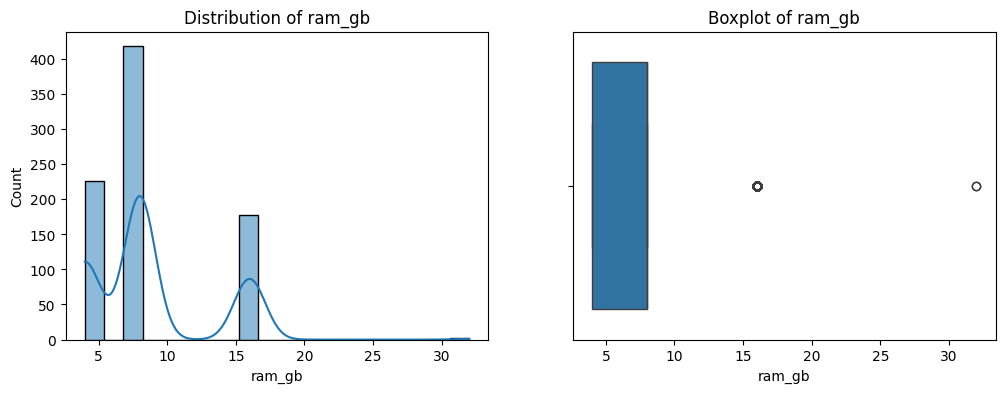

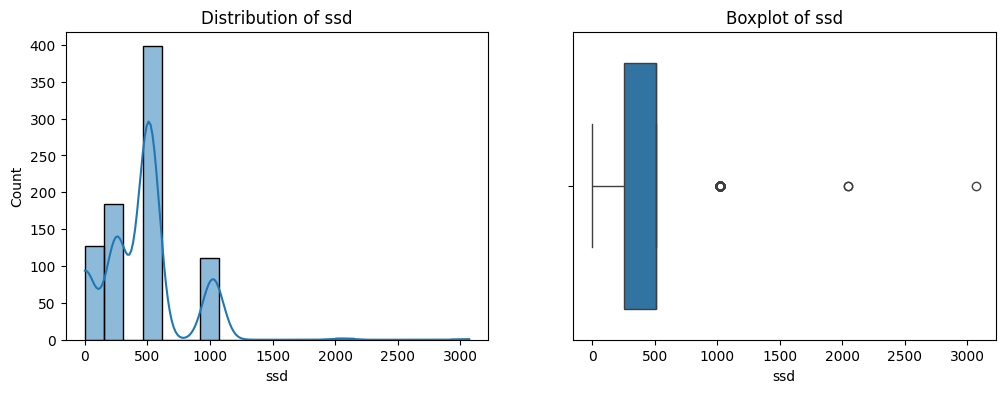

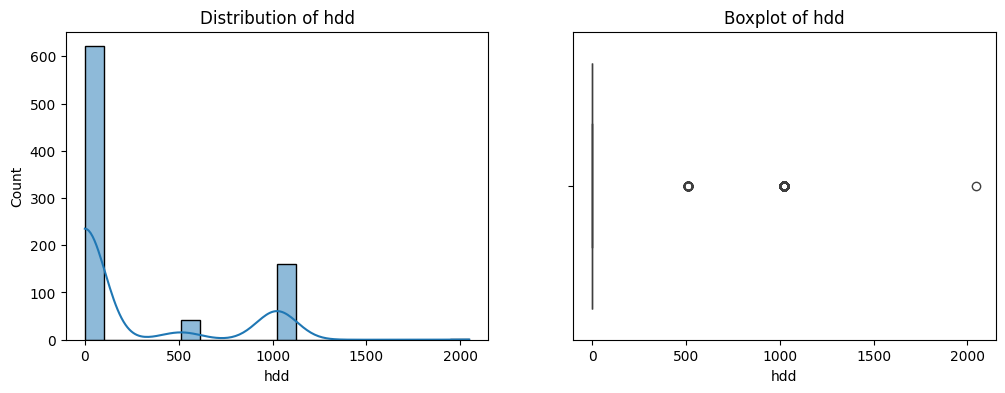

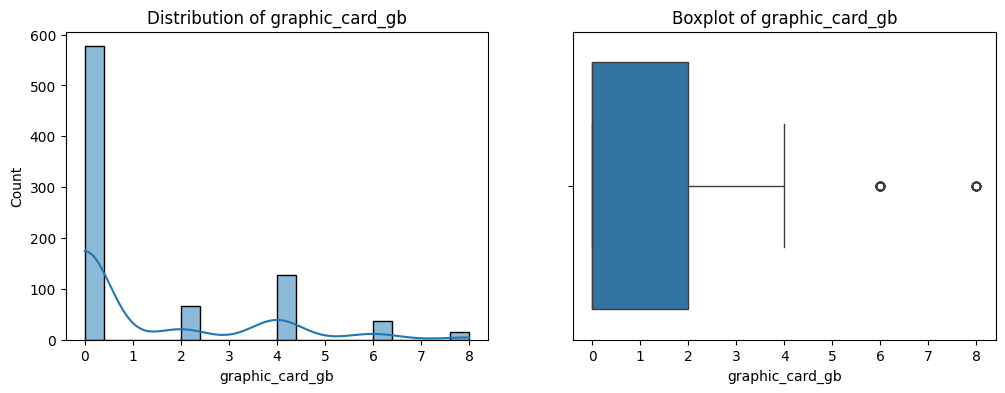

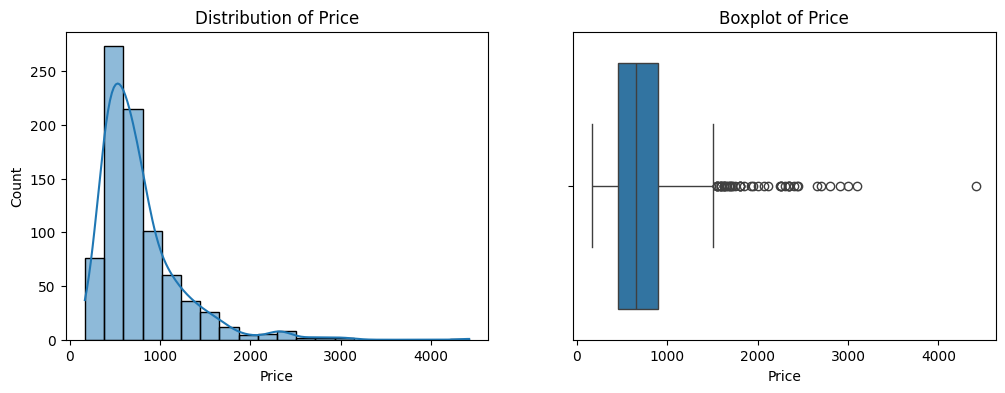

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 5a: Visualize numeric columns to check distributions
numeric_cols = ['ram_gb', 'ssd', 'hdd', 'graphic_card_gb', 'Price']

for col in numeric_cols:
    if df[col].notna().sum() < 2 or df[col].nunique() < 2:
        print(f"Skipping {col} — not enough variation for boxplot.")
        continue

    plt.figure(figsize=(12,4))

    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(df[col].dropna(), kde=True, bins=20)
    plt.title(f"Distribution of {col}")

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

before = df.shape[0]
df = df[(df['Price'] >= lower) & (df['Price'] <= upper)]
after = df.shape[0]

print(f"Removed {before - after} price outliers. New shape: {df.shape}")
print(df['Price'].describe())

Removed 50 price outliers. New shape: (773, 10)
count     773.000000
mean      683.880660
std       286.872095
min       169.900000
25%       449.900000
50%       619.900000
75%       829.900000
max      1510.980000
Name: Price, dtype: float64


I removed non-hardware columns, checked for missing values and duplicates, standardized text data, converted storage and memory values to numeric form, corrected the price scale, encoded categorical features, and removed outliers from the price column to prepare the dataset for modeling.

In [ ]:
# Feature Engineering

# 1. Create total storage (sum of SSD and HDD capacity)
df['total_storage'] = df['ssd'] + df['hdd']

# 2. Create a binary feature to mark presence of a dedicated GPU
df['has_dedicated_gpu'] = (df['graphic_card_gb'] > 0).astype(int)

# Preview new engineered features
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,graphic_card_gb,Price,total_storage,has_dedicated_gpu
0,2,1,1,0,4.0,1,0.0,1024.0,0.0,346.49,1024.0,0
1,6,1,1,0,4.0,1,0.0,1024.0,0.0,389.99,1024.0,0
2,6,1,1,0,4.0,1,0.0,1024.0,0.0,399.99,1024.0,0
3,2,1,2,0,8.0,1,512.0,0.0,2.0,699.90,512.0,1
4,2,1,0,7,4.0,1,0.0,512.0,0.0,269.90,512.0,0


Low-variance features: []


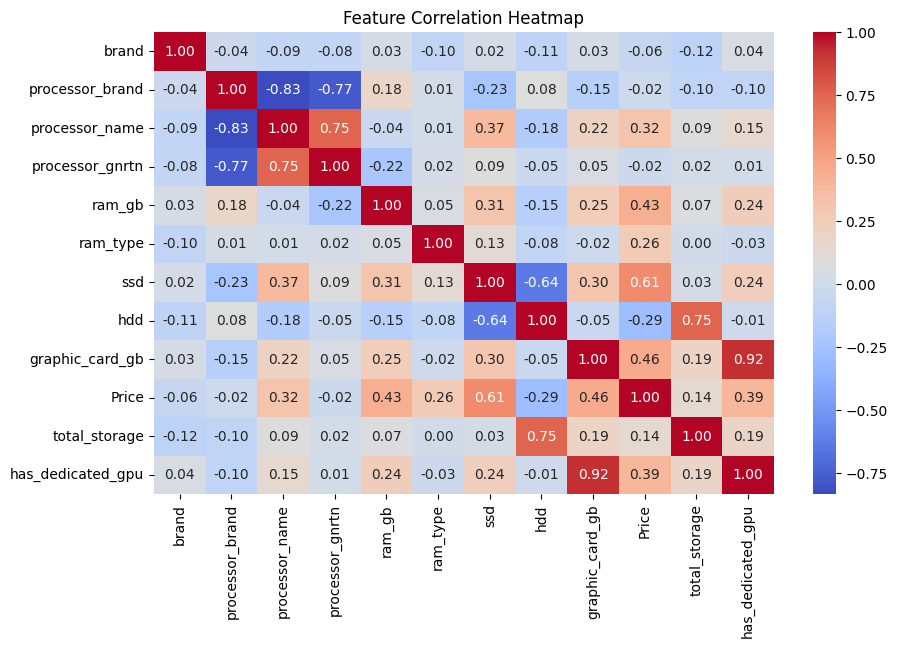


Feature importance (F-scores):
ssd                  445.637281
graphic_card_gb      208.952191
ram_gb               179.318538
has_dedicated_gpu    141.691479
processor_name        85.382959
hdd                   69.907790
ram_type              57.747513
total_storage         15.637009
brand                  2.948177
processor_gnrtn        0.462881
processor_brand        0.232036
dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, f_regression, SelectKBest

# Check for near-zero-variance features
vt = VarianceThreshold(threshold=0.01)
vt.fit(df.drop(columns=['Price']))
low_var = [col for col, keep in zip(df.columns, vt.get_support()) if not keep]
print("Low-variance features:", low_var)

# Correlation heatmap to spot redundancy
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# ANOVA / F-regression test to rank features by importance
X = df.drop(columns=['Price'])
y = df['Price']

anova = SelectKBest(score_func=f_regression, k='all')
anova.fit(X, y)
anova_scores = pd.Series(anova.scores_, index=X.columns).sort_values(ascending=False)
print("\nFeature importance (F-scores):")
print(anova_scores)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns (excluding the target)
numeric_cols = ['ram_gb', 'ssd', 'hdd', 'graphic_card_gb', 'total_storage']

# Scale numeric features (standardization → mean 0, std 1)
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("Scaled numeric columns:")
print(df[numeric_cols].head())

# Optional: one-hot encode categorical features if using linear models
df_encoded = pd.get_dummies(
    df,
    columns=['brand','processor_brand','processor_name','processor_gnrtn','ram_type'],
    drop_first=True
)

print("\nData shape after one-hot encoding:", df_encoded.shape)
df_encoded.head()

Scaled numeric columns:
     ram_gb       ssd       hdd  graphic_card_gb  total_storage
0 -1.069695 -1.530595  1.868154        -0.578723       1.118506
1 -1.069695 -1.530595  1.868154        -0.578723       1.118506
2 -1.069695 -1.530595  1.868154        -0.578723       1.118506
3 -0.068637  0.323146 -0.565010         0.509727      -0.457084
4 -1.069695 -1.530595  0.651572        -0.578723      -0.457084

Data shape after one-hot encoding: (773, 38)


,ram_gb,ssd,hdd,graphic_card_gb,Price,total_storage,has_dedicated_gpu,brand_1,brand_2,brand_3,...,processor_gnrtn_3,processor_gnrtn_4,processor_gnrtn_5,processor_gnrtn_6,processor_gnrtn_7,ram_type_1,ram_type_2,ram_type_3,ram_type_4,ram_type_5
0,-1.069695,-1.530595,1.868154,-0.578723,346.49,1.118506,0,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,-1.069695,-1.530595,1.868154,-0.578723,389.99,1.118506,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,-1.069695,-1.530595,1.868154,-0.578723,399.99,1.118506,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,-0.068637,0.323146,-0.565010,0.509727,699.90,-0.457084,1,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,-1.069695,-1.530595,0.651572,-0.578723,269.90,-0.457084,0,False,True,False,...,False,False,False,False,True,True,False,False,False,False


I created new features such as total storage and a dedicated GPU indicator to capture more hardware-related relationships. I checked for low-variance and highly correlated features using variance thresholding and a correlation heatmap, and evaluated feature importance with an ANOVA F-test. Then, I standardized all numeric columns using the StandardScaler to ensure consistent ranges for regression modeling and applied one-hot encoding to categorical variables so they could be used effectively by machine learning algorithms.

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (618, 37)
Testing set shape: (155, 37)


In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R² Score: 0.6677
Mean Absolute Error: 113.08
Root Mean Squared Error: 160.08


Since price is continuous, the data didn’t need balancing. I split the dataset 80/20 for training and testing, then used a Linear Regression model to predict laptop prices. The model got an R² of 0.67, meaning it explains about two-thirds of price variation. The average error was around 113 and the RMSE was $160, which is decent for a simple model based only on hardware specs. The model could improve if more features like display quality or brand reputation were included.

The goal of this project was to predict laptop prices using their specs like RAM, SSD, graphics card, and processor. After cleaning up the data, I found that SSD size, dedicated GPU, and RAM had the biggest impact on price, while things like brand and processor generation didn’t matter as much. The Linear Regression model got an R² of about 0.67, meaning it explained most of the changes in price based on the specs. Overall, it worked well for showing how hardware affects laptop cost, but it could be better if more details like display quality or brand reputation were added.
